In [13]:
import os, re, datetime
from queue import Queue
from Mouse_Data import Mouse_Data
from helpers import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size':16, 'font.family':'Times New Roman', 'axes.facecolor':'white'})  
# pd.set_option('display.max_rows', 10000)

In [14]:
# Notes on current animals:
# Below animals were done with broken manipulator (no up movement)
# SNA-123598: Some crashes with saline injection learned on day 5
# SNA-123599: Succesful saline injections and good performance
# SNA-123601: Note says this is the crashed session, Saline injection 
# SNA-123602: Crashes and failed anisomycin injections

# First batch with rapamycin, sessions 1 with shady injector
# SNA-123995: Rapamycin injections, good experiments
# SNA-123996: Rapamycin, some issues, but succesful injection

# Second batch 
# SNA-126687: Shitty cranio, saline injections
# SNA-126688: PBS, little issues
# SNA-123690: Rapamycin, little issues

root = 'D:/mStim_data/PSI/'
path_ext = '/microstim/Session Data/'

ctrl_IDs = ['SNA-123598', 'SNA-123599', 'SNA-123601', 'SNA-1236687', 'SNA-126688']
exp_IDs = ['SNA-123995','SNA-123996','SNA-123690'] # In this case it refers to 200 nL superficial rapamycin injection


In [15]:
x = Mouse_Data(root+ctrl_IDs[0] + path_ext)

ValueError: time data 'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Aug  3 12:20:07 2023' does not match format '%b %d %X %Y'

In [17]:
def get_sessions(files): #TODO probably create failsafe for different month/years
    ''' Create a list of files for individual session dates in self.files
    '''
    # Go through all files
    sessions = []
    for file in files:
        if file.endswith('.txt'):
            session = re.split('(?=[A-Z])', file)[0]
            # Get the unique sessions
            if '(' not in session:
                sessions.append(session)
    # Sort according to date
    sessions = set(sessions)
    sessions_date = sorted([datetime.datetime.strptime(session, '%d_%m_%Y') for session in sessions])
    sessions = [datetime.datetime.strftime(date, '%d_%m_%Y') for date in sessions_date]
    return sessions

def format_testData(text_df, testData, dtype):
    '''docstring'''
    # Get the timepoint of intensity change and link intensity to stimtimes
    i_change = text_df.loc[text_df[2].str.contains('Current')]
    data_dict = {'type':[],
                 'stim_t':[],
                 'response_t':[],
                 'intensity':[],
                 'succes':[]}
    
    # how is all data going to be formatted, every stimulus: catch, test,mix, pair with outcome n int?
    # Go through all type of stimulus responses
    for idx, stim_t in enumerate(testData['time']):
        # Check if the stimulus occured without having a documented intensity
        if stim_t <= np.min(i_change[0]):
            pass
        # If stim_t happened after an intensity change mark this
        else:
            exeed = np.where(stim_t > i_change[0])[0][-1]
            change_idx = i_change.index[exeed]

            # Get the newly set intensity
            try:
                intensity = np.float64(re.split(' |uA',i_change[2][change_idx])[-2].strip('.'))
            except:
                break

            # Put all the seperate DataFrames in a dictionary
            data_dict['type'].append(dtype)
            data_dict['stim_t'].append(stim_t)
            data_dict['response_t'].append(testData['rt'][idx])
            data_dict['intensity'].append(intensity)
            succes = testData['rt'][idx] <= 0.85 and testData['rt'][idx] >= 0.15
            succes = int(succes)
            data_dict['succes'].append(succes)

    # Make DataFrame and add to all_data dict
    data_dict = pd.DataFrame(data_dict) 
    return data_dict

def formatData(dataDict):
    ''' Grabs a the Mouse_Data dataframes and formats them in a single
        pd.DataFrame containing trialtype, stimulation and response time
        intensity and trial outcome. Uses format testData
        INPUT:
            dataDict(dict): predefined dictionary in Mouse_Data.get_behaviour() 
        OUTPUT:
            all_data(pd.DataFrame): formatted behaviour data per session with
                                    keys: type, stim_t, response_t, intensity
                                    and succes
            '''
    data_dict = {'type':[],
                 'stim_t':[],
                 'response_t':[],
                 'intensity':[],
                 'succes':[]}
    dtypes = dataDict.keys()
    text = dataDict['text']
    dfs = []
    for dtype, data in dataDict.items():
        if dtype != 'text':
            data_dict = format_testData(text, data, dtype)
            dfs.append(data_dict)
    df = pd.concat(dfs)
    df = df.sort_values(by=['stim_t'], ignore_index=True)
    df['succes'] = df['succes'].astype(bool)
    return df
    

In [20]:
class Mouse_Data:
    ''' Class designed for housing all data for an individual mouse
        
        INPUT:
            path_to_data(str): path to the mouse folder you want to extract the data from
            
        OUTPUT:
            Mouse_Data(Class): Dataclass with attributes like id, sessions, all_data and concatenated data
    '''    

    def __init__(self, path_to_data): 
        # From path_to_data get path and files in the raw-folder of that path
        self.path = path_to_data
        self.files = os.listdir(self.path)
        self.id = path_to_data.split('/')[-1]

        # Run functions that extract data from the files in path_to_data
        self.get_sessions()
        self.get_behaviour()
        self.compile_data()

    def get_sessions(self): #TODO probably create failsafe for different month/years
        ''' Create a list of files for individual session dates in self.files
        '''
        # Go through all files
        sessions = []
        for file in self.files:
            if file.endswith('.txt'):
                session = re.split('(?=[A-Z])', file)[0]
                # Get the unique sessions
                if '(' not in session:
                    sessions.append(session)
        # Sort according to date
        sessions = set(sessions)
        sessions_date = sorted([datetime.datetime.strptime(session, '%d_%m_%Y') for session in sessions])
        sessions = [datetime.datetime.strftime(date, '%d_%m_%Y') for date in sessions_date]
        self.sessions = sessions
        
    def get_behaviour(self):
        ''' Creates self.all_data a dictionary with keys being session_dates and values being a pd.Dataframe 
        '''
        self.all_data = dict.fromkeys(self.sessions)
        # For all sessions
        for session in self.sessions:
            # Check if file belongs to session
            for file in self.files:
                if session in file:
                    
                    if 'TextMarks' in file:
                        text_df = pd.read_csv(self.path+file, delimiter='\t', header=None)
                        text_df = text_df.fillna('NaN')
                        
                    if 'ReactCalcrTXT' in file: # Abstraction of pairing trials
                        try:
                            pairData = pd.read_csv(self.path+file, delimiter='\t', header=None, names=['time', 'rt'] ,skiprows=1)
                            pairData['rt'] = 0
                        except: 
                            # Create empty df
                            pairData = pd.DataFrame(data={'time':[None], 'rt':[None]})
                            print(f'No reward/pairing info in {self.path+file}')
                            
                    if 'ReactCalctTXT' in file:
                        try: 
                            testData = pd.read_csv(self.path+file, delimiter='\t', header=None, names=['time', 'rt'] ,skiprows=1)
                        except:
                            testData = pd.DataFrame(data={'time':[None], 'rt':[None]})
                            print(f'No testing info in {self.path+file}') 
                            
                    if 'ReactCalccTXT' in file:
                        try:
                            catchData = pd.read_csv(self.path+file, delimiter='\t', header=None, names=['time', 'rt'] ,skiprows=1)
                        except:
                            catchData = pd.DataFrame(data={'time':[None], 'rt':[None]})
                            print(f'No catch info in {self.path+file}')
                            
                    if 'ReactCalcmTXT' in file:
                        try:
                            mixData = pd.read_csv(self.path+file, delimiter='\t', header=None, names=['time', 'rt'], skiprows=1)
                        except:
                            mixData = pd.DataFrame(data={'time':[None],'rt':[None]})
                            print(f'No mix info in {self.path+file}')
                            
            dataDict = {'text':text_df, 'pairData':pairData, 'testData':testData, 'catchData':catchData,'mixData':mixData}
            data_dict = formatData(dataDict)
            self.all_data[session] = data_dict
                        
    def compile_data(self):
        ''' Creates one big pd.DataFrame of all stimuli over all sessions'''
        df_full = pd.DataFrame()
        for session in self.sessions:
            df_full = pd.concat([df_full, self.all_data[session]])
        self.full_data = df_full      


In [26]:
x = Mouse_Data(root+ctrl_IDs[0] + path_ext)
print(x.full_data)

Empty DataFrame
Columns: []
Index: []


In [5]:
 def plot_raster_rt(mouse, catch=False, save=False, peak=False):
    ''' Creates a figure containing rasterplots of the trial response time.

        INPUT:
            mouse(Mouse_Data): Dataclass with attributes like id, sessions, all_data and concatenated data
            catch(bool): do you want to show the catch trials as well
            save(bool): prompts the user for destination folder path
            peak(bool): if true only two session rasterplots will be created
        OUTPUT:
            raster_rt_plot(matplotlib.plt): either a plot is shown or saved
    '''
    # Check for peaking allowing the user to only see the plots of the first 2 sessions
    if peak:
        n_sessions = 2
    else:
        n_sessions = len(mouse.sessions)
    # Set figure basics 
    fig, axs = plt.subplots(1, n_sessions, figsize=(15, 10)) # Size plot according to the number of sessions
    plt.subplots_adjust(wspace=1,) 
    fig.patch.set_facecolor('white')
    fig.suptitle(str(mouse.id), y=1.05)
    
    # Create legend patches
    gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')
    orange_patch = matplotlib.patches.Patch(color='orange', label='Catch trials')
    red_patch = matplotlib.patches.Patch(color='red', label='Incorrect trials')
    blue_patch = matplotlib.patches.Patch(color='blue', label='Pairing trials')
    green_patch = matplotlib.patches.Patch(color='green', label='Succesful trials')
    
    # Get and plot data for every session
    for idx, session in enumerate(mouse.sessions):
        if peak and idx == n_sessions:
            break
        colors = []
        
        # For pairing only pair and mix data are important
        if catch:
            select_data = mouse.all_data[session].loc[(mouse.all_data[session]['type'] == 'catchData')|(mouse.all_data[session]['type'] == 'mixData')|(mouse.all_data[session]['type'] == 'pairData')]        
            patches = [gray_patch, blue_patch, green_patch, red_patch, orange_patch]
        else:
            select_data = mouse.all_data[session].loc[(mouse.all_data[session]['type'] == 'pairData')|(mouse.all_data[session]['type'] == 'mixData')]        
            patches = [gray_patch, blue_patch, green_patch, red_patch]
        
        # Aquire response time, xticks and datatype
        rt_full = select_data['response_t']
        x = np.arange(0, len(rt_full), 1) # Initiate x-axis for plotting
        rt = [[rt] for rt in rt_full] # plt.eventplot requires values as list to ascribe different offsets
        dtype = [[dtype] for dtype in select_data['type']]

        # Pick right color
        for _, trial in select_data.iterrows():
            trial_succes = trial['succes']
            trial_intensity = trial['intensity']
            if trial['type'] == 'catchData':
                c = 'orange'
            elif trial['type'] == 'mixData':
                if trial_succes:
                    c = 'green'
                else:
                    c = 'red'
            elif trial['type'] == 'pairData':
                c = 'blue'
            colors.append(c)
            
        # Now the plot
        # If there are multiple sessions
        if len(mouse.sessions) > 1:
            for x in np.arange(0, 0.15, 0.001):
                axs[idx].axvline(x, color='gray')
            offset = np.arange(0, len(rt), 1)
            axs[idx].eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
            axs[idx].set_xlim([-0.2, 1.])
            axs[idx].set_ylabel('Trial #')
            axs[idx].invert_yaxis()
            axs[idx].set_xlabel('Response time (s)')
            axs[idx].set_title(str(session))
            axs[idx].set_xticks(np.arange(0, 1, 0.2))
            legend = axs[0].legend(bbox_to_anchor=(0., 1.1, 1., .02), handles=patches, mode="expand", borderaxespad=0., ncol=1)
        
        # If there is just one sessions
        else:
            for x in np.arange(0, 0.15, 0.001):
                axs.axvline(x, color='gray')
            offset = np.arange(0, len(rt), 1)
            axs.eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
            axs.set_xlim([-0.2, 1.])
            axs.set_ylabel('Trial #')
            axs.invert_yaxis()
            axs.set_xlabel('Response time (s)')
            axs.set_title(str(session))
            legend = axs.legend(bbox_to_anchor=(0., 1.1, 1., .102), handles=patches, mode="expand", borderaxespad=0., ncol=1)
    
    # Prompt user for destination folder path or show the plot
    if save:
        fname = input('What path do you want to save the .jpg to?')
        fig.savefig(fname+mouse.id+'.jpg', bbox_inches='tight')   
    else:   
        plt.show()
    return

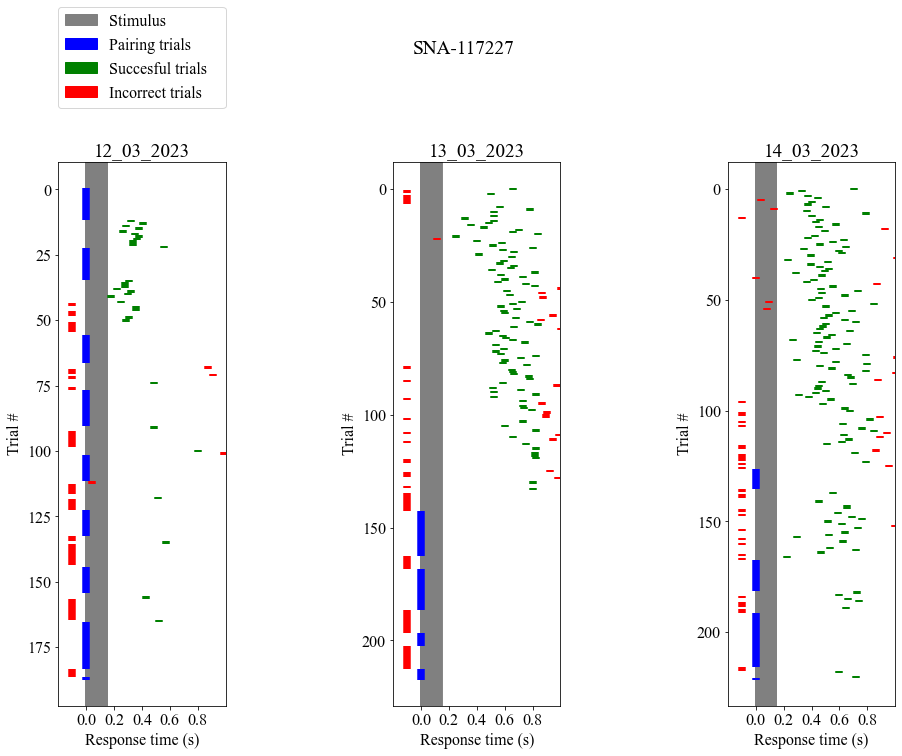

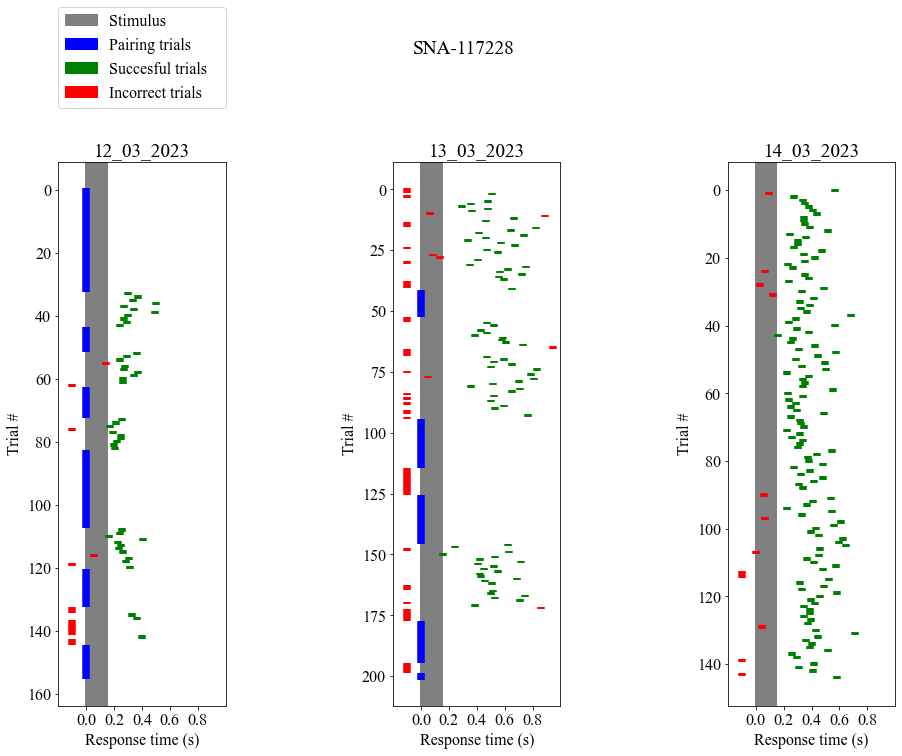

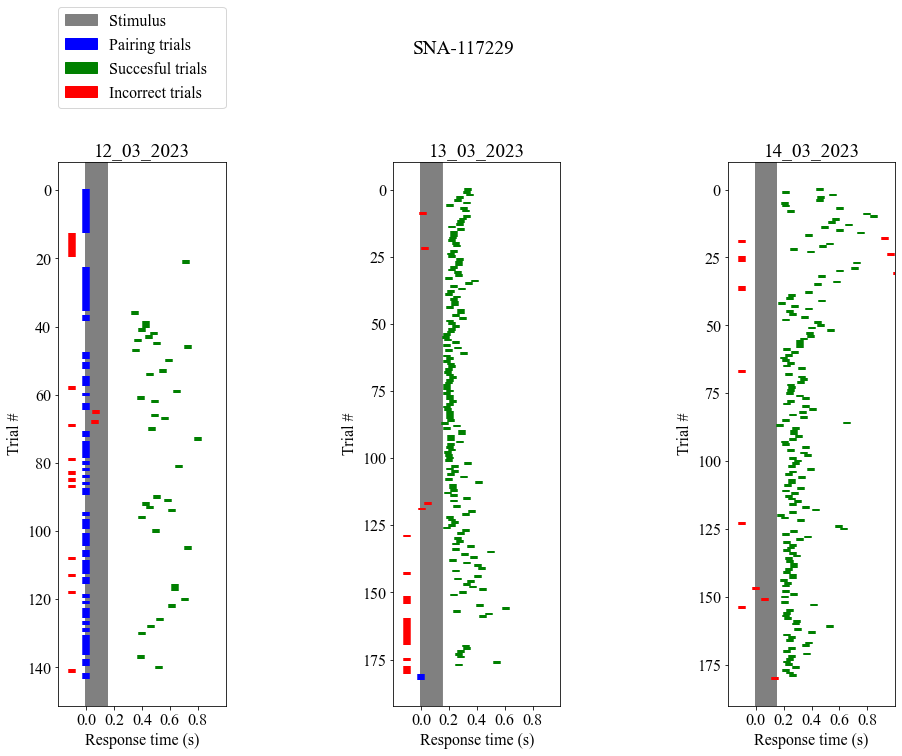

In [8]:
mice = []
for ID in mouseIDs:
    mouse = Mouse_Data(path+ID)
    mice.append(mouse)
    plot_raster_rt(mouse)

In [9]:
def select_trialType(mouse_data, trialType):
    '''docstring
    '''
    # Define allowed trialtypes and check input
    allowed_trialTypes = ['pairData', 'testData', 'catchData', 'mixData']
    if trialType not in allowed_trialTypes:
        raise NameError('trialType not found')
    typeData = mouse_data.loc[mouse_data['type'] == trialType]
    return typeData
    
def get_hitnmiss(mouse_data):
    ''' docstring
    '''
    hits = mouse_data.loc[mouse_data['succes'] == True]
    misses = mouse_data.loc[mouse_data['succes'] == False]
    return len(hits), len(misses)

In [10]:
def plot_performance(mouse_data, average=False):
    ''' docstring
    '''
    # If you want to plot the average, check input and get n_sessions
    if average:
        title = 'Average'
        if not isinstance(mouse_data, list):
            raise TypeError('mouse_data should be a list of Mouse_Data Classes')
            return
        else:
            bigdict = {'mHit':[],'mMiss':[], 'mTotal':[], 'mRT':[],
                   'cHit':[],'cMiss':[], 'cTotal':[], 'cRT':[]}
            n_sessions = np.max([len(mouse.sessions) for mouse in mouse_data])
            xticks = np.arange(0, n_sessions, 1)
            massivedict = {n:bigdict.copy() for n in xticks}
    else:   
        title = mouse_data.id
        n_sessions = len(mouse_data.sessions)
        xticks = np.arange(0, n_sessions, 1)
        
    # Set plot 
    fig, axs = plt.subplots(4, figsize=(20, 20))
    fig.patch.set_facecolor('white')

    # Get the data to plot
    if average:
        
        for n_session in xticks:
            for mouse in mouse_data:
                session = mouse.sessions[n_session]
                mixData = select_trialType(mouse.all_data[session], 'mixData')
                catchData = select_trialType(mouse.all_data[session], 'catchData')

                # Gather data about mix (test) trials
                mHit, mMiss = get_hitnmiss(mixData)
                mRT = np.mean(mixData['response_t'])
                mRTsem = np.std(mixData['response_t'].loc[mixData['succes']==True])
                mTotal = mHit + mMiss
                # Catch trials
                cHit, cMiss = get_hitnmiss(catchData)
                cRT = np.mean(catchData['response_t'])
                cRTsem = np.std(catchData['response_t'].loc[catchData['succes']==True])
                cTotal = cHit + cMiss
                
                # Add to the big dict
                bigdata = {'mHit':mHit,'mMiss':mMiss, 'mTotal':mTotal, 'mRT':mRT,
                   'cHit':cHit,'cMiss':cMiss, 'cTotal':cTotal, 'cRT':cRT}
                [massivedict[n_session][key].append(bigdata[key]) for key in bigdata.keys()]

                # Unpack for ease of use after all sessions of a single mouse have been added
            mHit = np.mean(massivedict[n_session]['mHit'])
            mMiss = np.mean(massivedict[n_session]['mMiss'])
            mTotal = np.mean(massivedict[n_session]['mTotal'])
            mRT = np.mean(massivedict[n_session]['mRT'])
            cHit = np.mean(massivedict[n_session]['cHit'])
            cMiss = np.mean(massivedict[n_session]['cMiss'])
            cTotal = np.mean(massivedict[n_session]['cTotal'])
            cRT = np.mean(massivedict[n_session]['cRT'])
            
            n=n_session
            axs[0].bar([n-0.2, n+0.2], [mHit, cHit], color=['blue', 'red'], width=0.4)
            axs[1].bar([n-0.2, n+0.2], [(mHit/mTotal)*100, (cHit/cTotal)*100], color=['blue', 'red'], width=0.4)
            axs[2].bar([n-0.2, n+0.2], [(mHit/mTotal-cHit/cTotal)*100], color=['purple'], width=0.4)
            axs[3].bar([n-0.2, n+0.2], [mRT,cRT], color=['blue', 'red'], width=0.4)#, yerr=[mRTsem,cRTsem])

    else:
        for n, session in enumerate(mouse_data.sessions):
            # Gather data about mix (test) trials
            mixData = select_trialType(mouse_data.all_data[session], 'mixData')
            mHit, mMiss = get_hitnmiss(mixData)
            mRT = np.mean(mixData['response_t'])
            mRTsem = np.std(mixData['response_t'].loc[mixData['succes']==True])
            mTotal = mHit + mMiss
            # Catch trials
            catchData = select_trialType(mouse_data.all_data[session], 'catchData')
            cHit, cMiss = get_hitnmiss(catchData)
            cRT = np.mean(catchData['response_t'])
            cRTsem = np.std(catchData['response_t'])
            cTotal = cHit + cMiss

            # Total hits and misses
            axs[0].bar([n-0.2, n+0.2], [mHit, cHit], color=['blue', 'red'], width=0.4)
            # Hit rate
            axs[1].bar([n-0.2, n+0.2], [(mHit/mTotal)*100, (cHit/cTotal)*100], color=['blue', 'red'], width=0.4)
            # Hits - Falsepositives
            axs[2].bar([n-0.2, n+0.2], [(mHit/mTotal-cHit/cTotal)*100], color=['purple'], width=0.4)
            # Reaction time
            axs[3].bar([n-0.2, n+0.2], [mRT,cRT], color=['blue', 'red'], width=0.4, yerr=[mRTsem/3,cRTsem/3])
            
    # Configure        
    fig.suptitle(title, y=.925)  
    axs[0].set_title('Microstim and Catch Hits')
    axs[0].set_ylim([0, 180])
    axs[0].set_xticks(xticks)
    axs[0].set_ylabel('Hits')    
    axs[1].set_ylim([0, 100])
    axs[1].set_xticks(xticks)
    axs[1].set_ylabel('Hit rate (%)')
    axs[1].axhline(y=[50], color='gray', linestyle='--')
    axs[2].set_ylim([0, 100])
    axs[2].set_xticks(xticks)
    axs[2].set_ylabel('Hits - FPs (%)')
    axs[3].set_ylim([0, 0.7])
    axs[3].set_ylabel('Reaction Time (s)')
    axs[3].set_xticks(xticks)
    axs[3].set_xlabel('Test day')
    # Add legend
    blue_patch = matplotlib.patches.Patch(color='blue', label='Microstim')
    red_patch = matplotlib.patches.Patch(color='red', label='Catch')
    legend = axs[0].legend(bbox_to_anchor=(0., 1.2, 1., .102), handles=[blue_patch, red_patch], loc='upper left', borderaxespad=0., ncol=1)
    
    plt.show()
    return

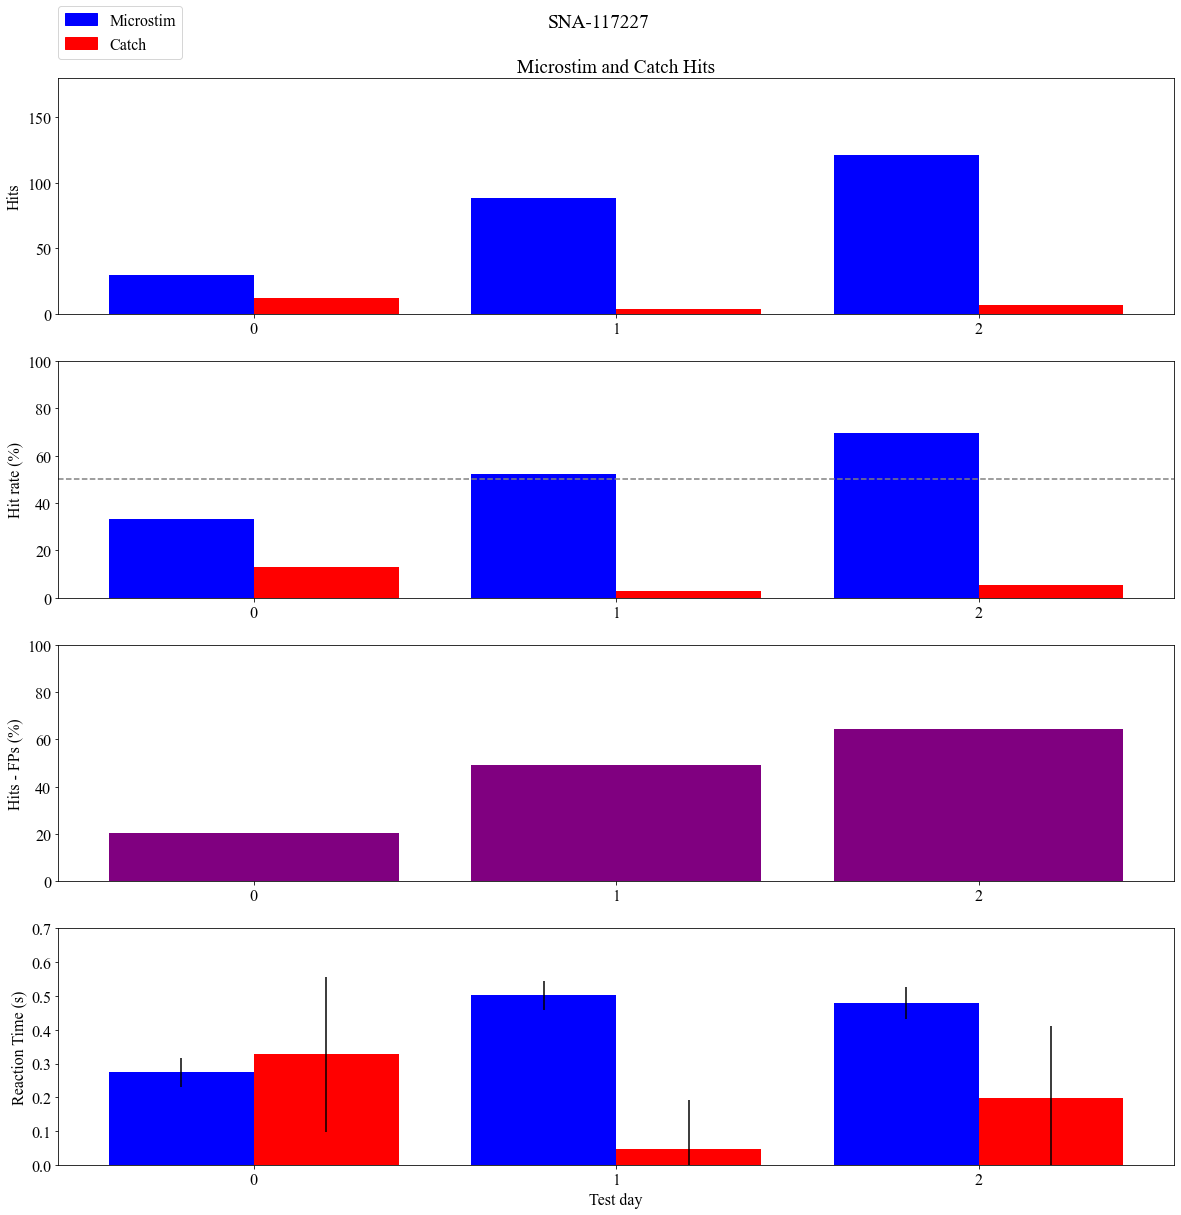

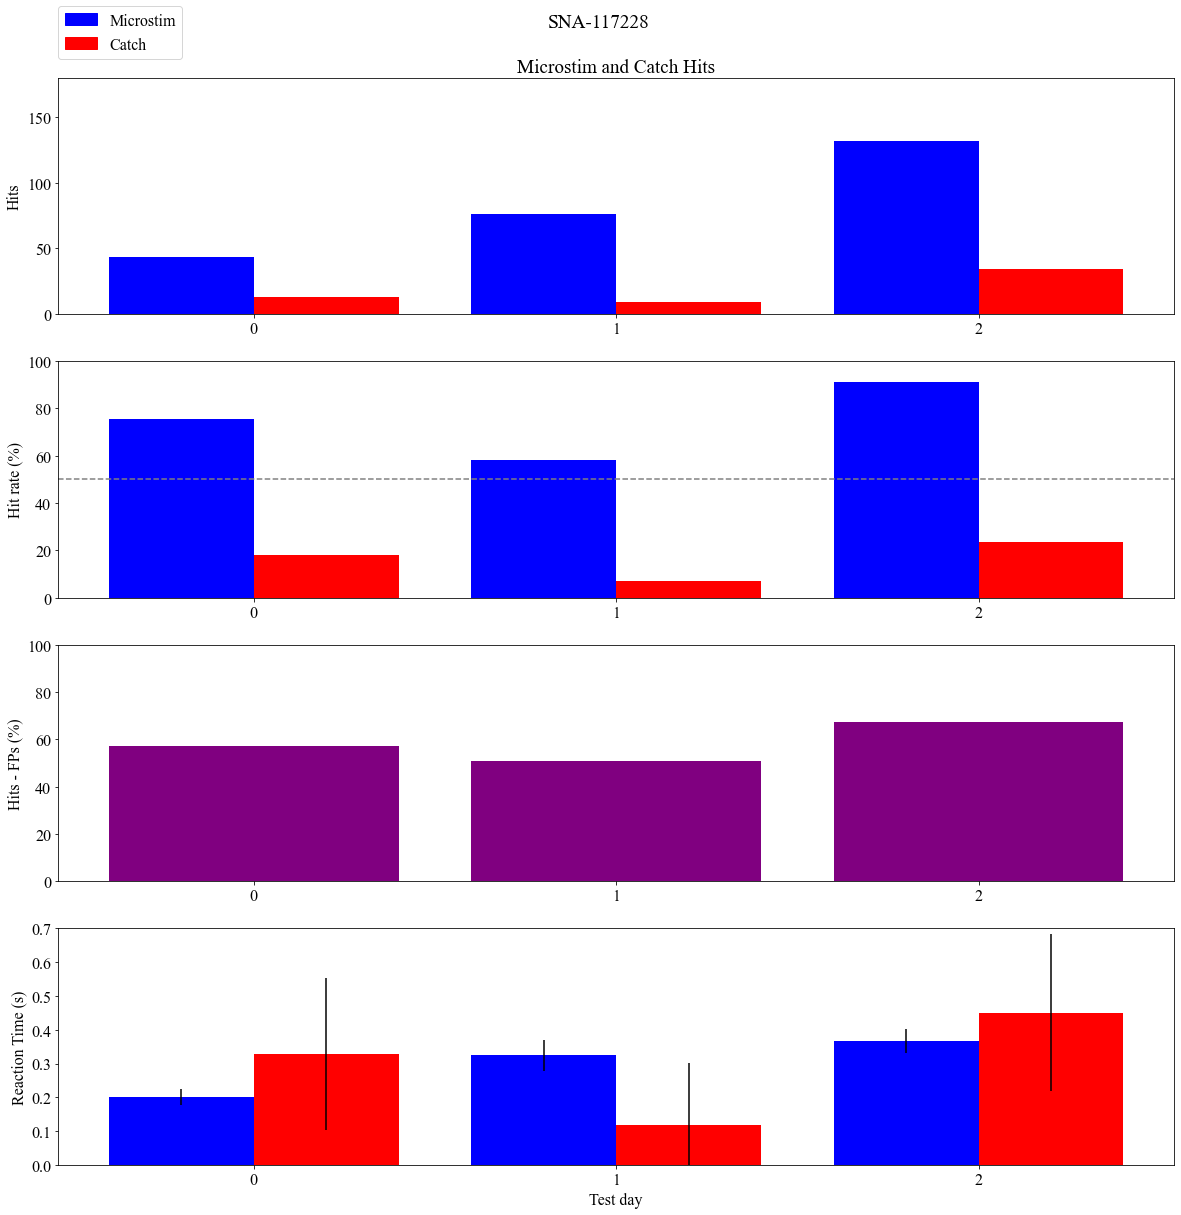

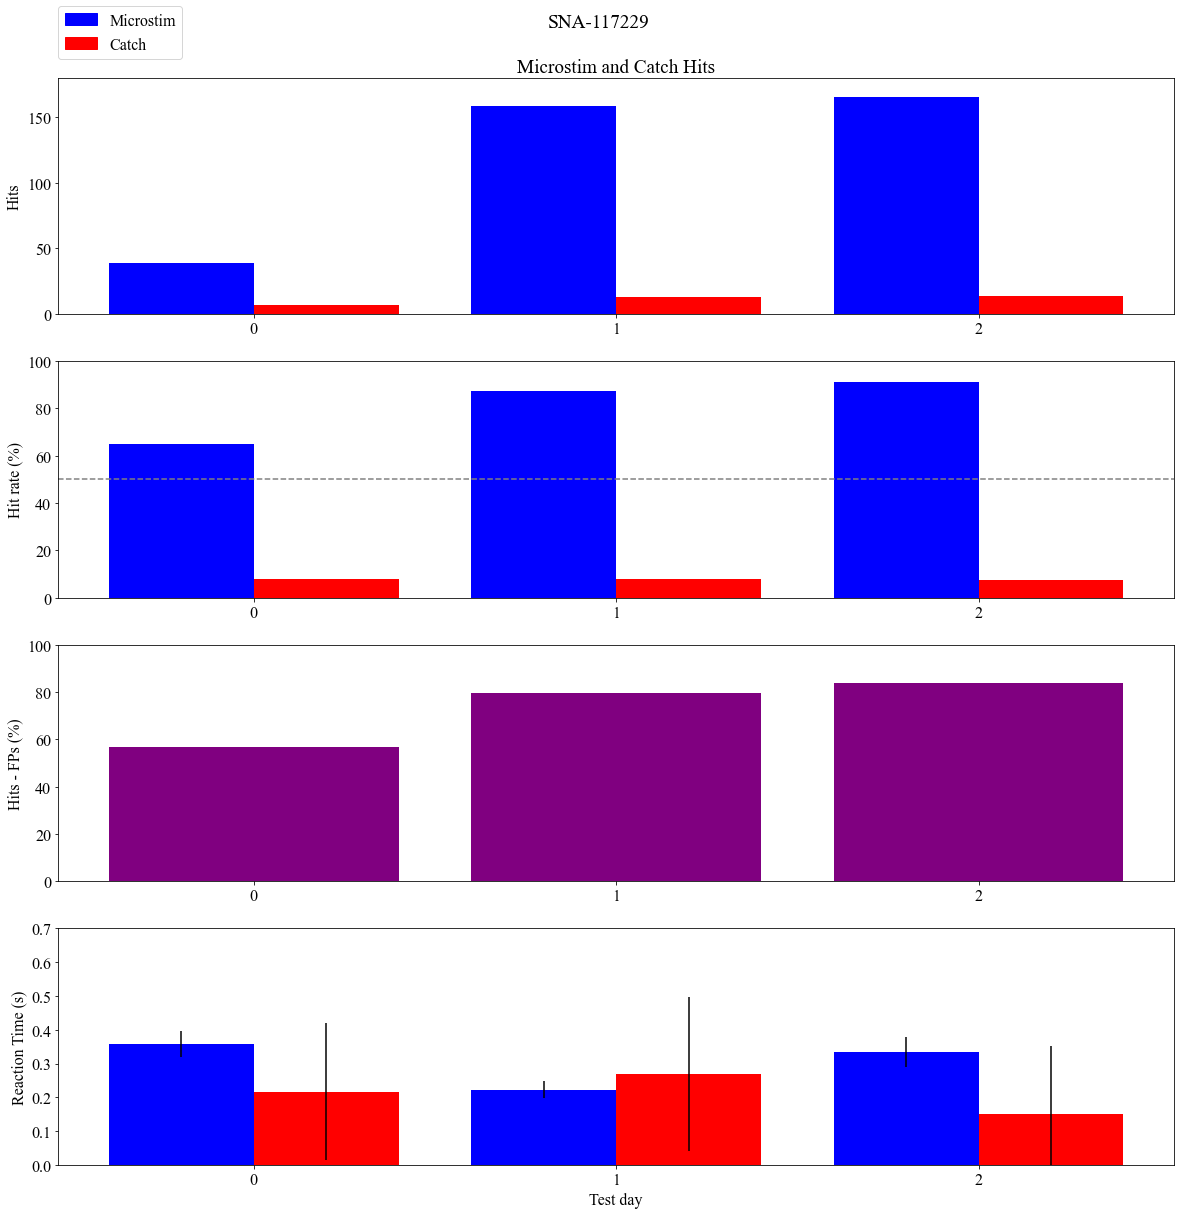

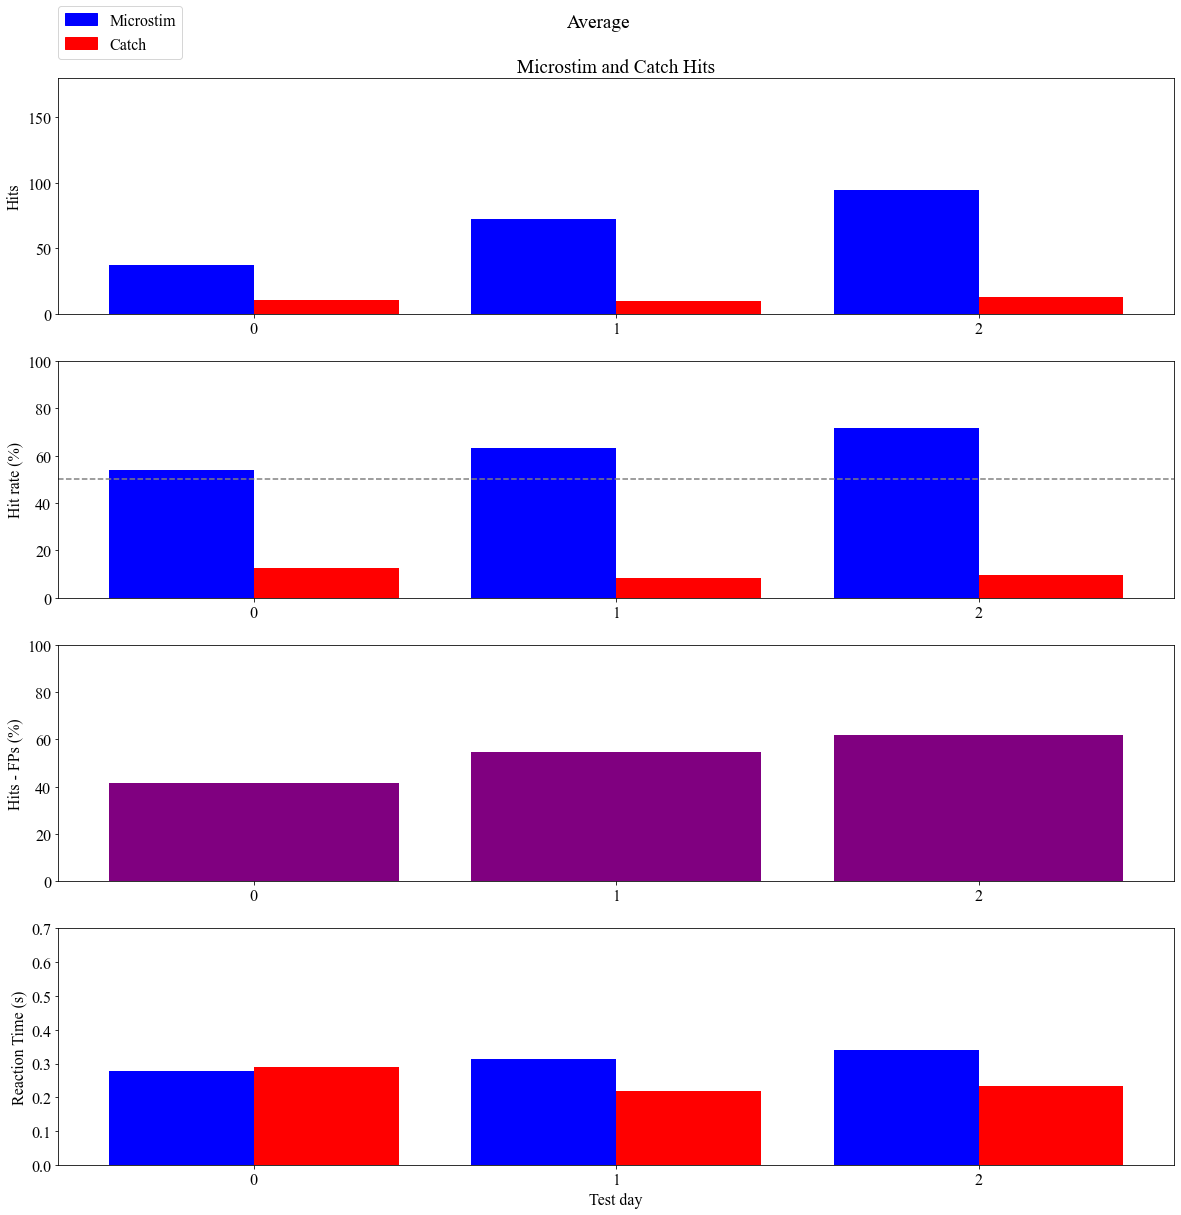

In [11]:
# mouse = Mouse_Data(path+mouseIDs[1])
mice = []
for ID in mouseIDs:
    mouse = Mouse_Data(path+ID)
    mice.append(mouse)
    plot_performance(mouse, average=False)
plot_performance(mice, average=True)


SNA-117227


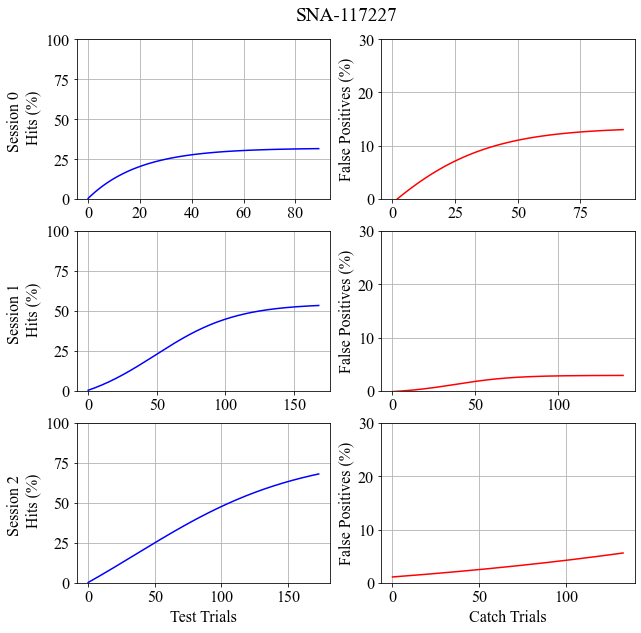

SNA-117228


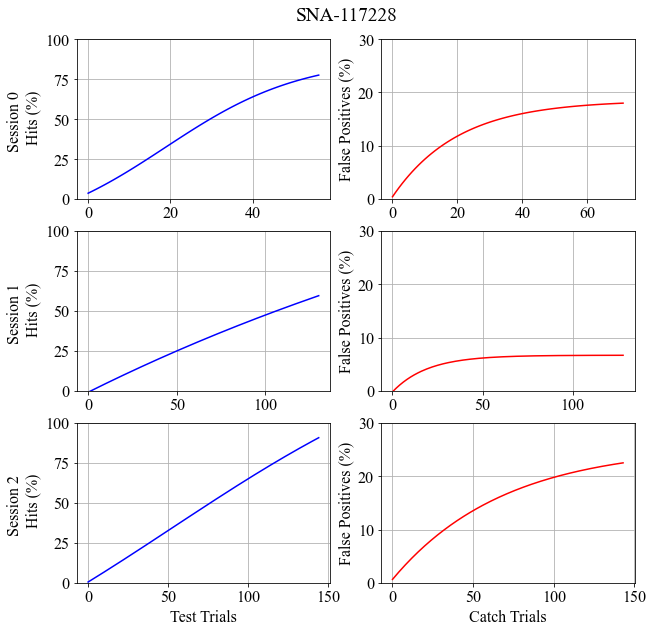

SNA-117229


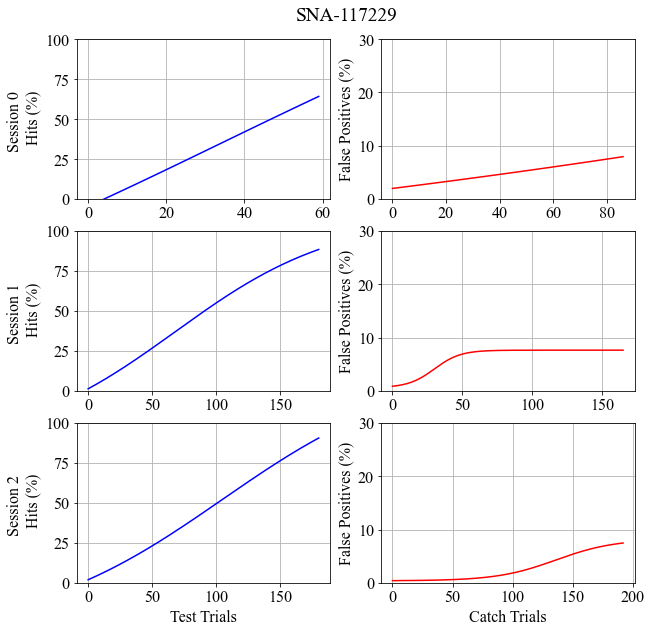

In [17]:
# False positives over session
# mouse 
def exponential(params, x, y):
    a, b = params
    residuals = y - (a * np.exp(b*x))
    return residuals

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def fit_sigmoid(x, y):
    p0 = [max(y), np.median(x), 1, min(y)]
    popt, pcov = curve_fit(sigmoid, x,y,p0, maxfev=10000)
    L ,x0, k, b = popt
    y_fit = sigmoid(x, L, x0, k, b)
    return y_fit

def plot_trialPerformance(mouse_data):
    '''docstring'''
    title = mouse_data.id
    n_sessions = len(mouse_data.sessions)
    xticks = np.arange(0, n_sessions, 1)
        
    # Set plot 
    fig, axs = plt.subplots(n_sessions,2, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    
    # Plot the progression of hit trials on the left side
    for n, session in enumerate(mouse.sessions):
        mixData = select_trialType(mouse.all_data[session], 'mixData')
        mscore = []
        mhit = 0
        mtotal = len(mixData)
        for idx, mixTrial in mixData.iterrows():
            if mixTrial['succes'] == True:
                mhit += 1
            mscore.append(mhit/mtotal*100)
        
        # Try to get a fit for mTrials
        x = np.arange(0, len(mscore), 1)
        y = mscore
        y_fit = fit_sigmoid(x, y)
        axs[n,0].plot(y_fit, c='blue')
        axs[n,0].set_ylabel(f'Session {n} \n Hits (%)')
        axs[n,0].set_ylim([0, 100])
        axs[n,0].grid()
        axs[-1,0].set_xlabel('Test Trials')

        
        catchData = select_trialType(mouse.all_data[session], 'catchData')
        total = 0
        FP = 0
        score = []
        total = len(catchData)
        for idx, catchTrial in catchData.iterrows():
            if catchTrial['succes'] == True:
                FP += 1
            score.append((FP/total)*100)
        
        # Try to get a fit
        x = np.arange(0, len(score), 1)
        y = score
        y_fit = fit_sigmoid(x, y)
        
        axs[n,1].plot(y_fit, c='red')
        axs[n,1].set_ylabel('False Positives (%)')
        axs[n,1].set_ylim([0, 30])
        axs[n,1].grid()
        axs[-1,1].set_xlabel('Catch Trials')
        

    fig.suptitle(title, y=.925)  
    plt.show()
    return

mice = []
for ID in mouseIDs:
    print(ID)
    mouse = Mouse_Data(path+ID)
    mice.append(mouse)
    plot_trialPerformance(mouse)

In [18]:
def get_cum_score(mouse): #TODO change this to yield all parameters over all sessions
    ''' Calculates the cumulative or learning score progressing over all trials
        
        INPUT:
            mouse(Mouse_Data): class with attributes like id, sessions, all_data and concatenated data
        OUPUT:
            session_cum_score(list): the cumulative score over all trails
    '''
    # We want a list of how the score for every trial and a last score to make it cumulative
    cum_scores = []
    last_score = 0

    # Go through all sessions
    for session in mouse.sessions:
        total, hits, misses = [0, 0, 0]
        session_data = mouse.all_data[session]
        session_dataTest = session_data.loc[session_data['type'] == 'mixData']
        
        # Check if trail was a hit or miss
        for idx, trial in session_dataTest.iterrows():
            total += 1
            if trial['succes'] == True:
                hits += 1
            else:
                misses += 1
                
            # Update the cum. score
            trial_cum_score = (hits - misses)  + last_score
#             trial_cum_score = ((hits - misses) + last_score)/total

            cum_scores.append(trial_cum_score)
        
        # Add the last value of the previous session to make it cumulative
        last_score = trial_cum_score
    return cum_scores

[281, 639, 995]


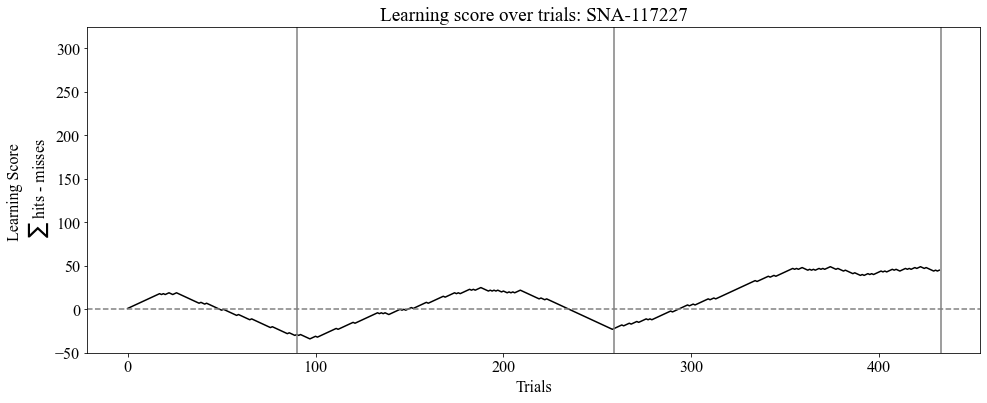

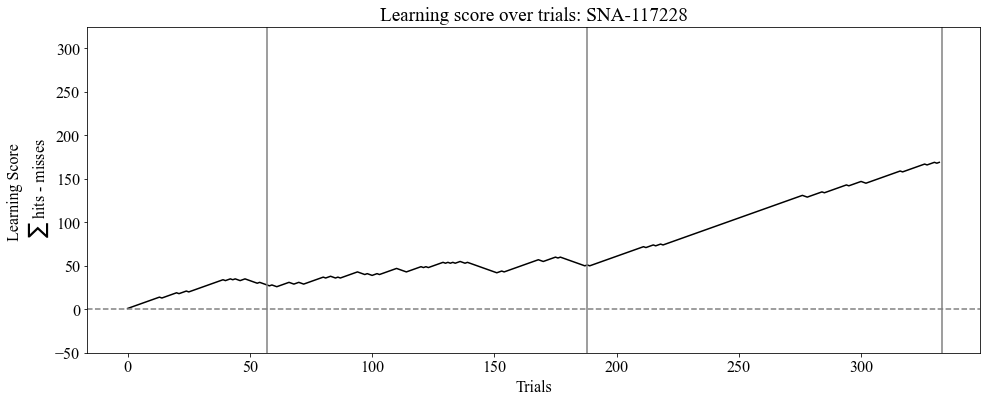

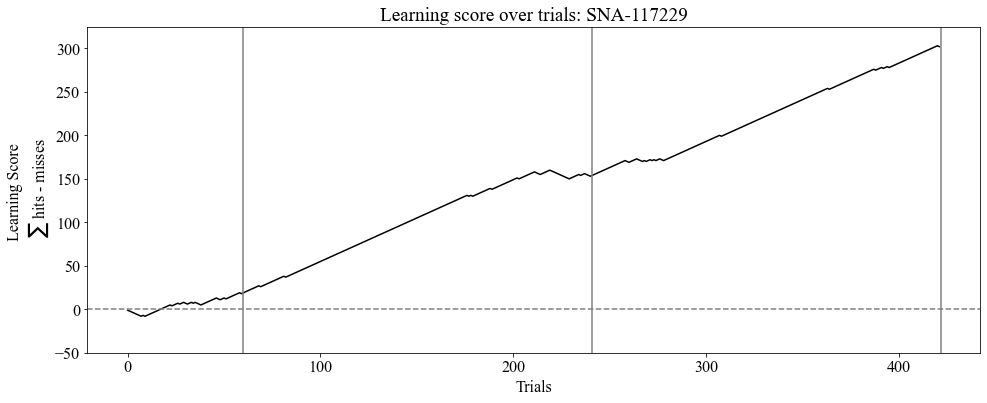

In [21]:
mouse = mice[0]
cum_score = get_cum_score(mouse)

lens = []
pre_l = 0
for session in mouse.sessions:
    data = mouse.all_data[session]
    l = len(data)
    l += pre_l
    pre_l = l
    lens.append(l)
print(lens)

def plot_LS(mouse):
    '''docstring'''
    sesh_l = []
    pre_l = 0
    for session in mouse.sessions:
        data = mouse.all_data[session].loc[mouse.all_data[session]['type']=='mixData']
        l = len(data) + pre_l
        sesh_l.append(l)
        pre_l = l
    
    cum_score = get_cum_score(mouse)
    fig = plt.figure(figsize=(16,6))
    fig.patch.set_facecolor('white')  
    plt.plot(cum_score, c='black')
    plt.axhline(0, linestyle= '--', c='gray')
    plt.ylabel(f'Learning Score \n $\sum$ hits - misses')
    plt.xlabel('Trials')
    plt.title(f'Learning score over trials: {mouse.id}')
#     plt.xlim([0, 400])
    plt.ylim([-50, 325])
    [plt.axvline(l, c='gray') for l in sesh_l]
    plt.show()

for mouse in mice: 
    plot_LS(mouse)
#     plot_raster_rt(mouse, catch=True)

In [ ]:
weights = {'SNA-117227':[13.91, 14.90, 15.56],
          'SNA-117228':[11.22, 14.97, 16.32],
          'SNA-117229':[13.20, 14.52, 15.84]}

In [39]:
''' Now we try to get determine if the FP% decreases over the sessions '''
# Select the dataframe of a single session
mouse = mice[0]

def plot_falsePositives(mouse_data, max_n=10, whiskey_n=0):
    '''docstring'''
    # Get some figure basics and set plot
    title = mouse_data.id
    n_sessions = len(mouse_data.sessions)
    fig = plt.figure(figsize=(16,6))
#     fig.patch.set_facecolor('white')
    colors = ['red', 'orange', 'green']
    FP_dict = {}
    
    # Go through sessions and determine FP score for each trial
    max_length = []
    for n_sesh, session in enumerate(mouse.sessions):
        data = mouse.all_data[session]

        # Lets get all the catchtrial data
        catchData = select_trialType(data, 'catchData')
        max_length.append(len(catchData))
        
        # Create an empty list to keep updating the score on
        FP_score = []
        FP_queue = Queue(maxsize=max_n)
        FP_avg = []
        pastTrials, hits = [whiskey_n,whiskey_n]
        i = 0
        for _, trial in catchData.iterrows():
            i += 1
            pastTrials += 1

            # Check if it was a hit or not    
            if trial['succes']:
                hits += 1
            score = (hits/pastTrials)*100
#             relative_pastTrials = (pastTrials/len(catchData))*100
#             score = score/pastTrials
            FP_score.append(score)

            # Drop as soon as the queue reaches max length
            if i >= max_n:
                FP_queue.get()
            FP_queue.put(score)
            FP_avg.append(np.mean(FP_queue.queue)) 
        FP_dict[n_sesh] = FP_avg
        # FP(%) over trials
#         plt.plot(FP_avg, label=session, c=colors[n_sesh])

        # FP(%) over trial (%)
#         plt.plot(np.linspace(0, 100,len(FP_avg)), FP_avg, label=session, c=colors[n_sesh])

        # Whiskey method 
        FP_avg = FP_avg[whiskey_n:]
        plt.plot(np.linspace(0, 100,len(FP_avg)), FP_avg, label=session, c=colors[n_sesh])
        
    plt.legend()
    plt.title(f'Progression of False Positives during the sessions of: {title}')
    plt.ylabel('FP (%)')
    plt.xlabel('Completed catch trials (%)')
#     plt.xlabel('Catch trial #')
#     plt.xlim([max_n, len(catchData)])
#     plt.xticks(np.arange(0, np.max(max_length), 20))
    plt.show()
    return FP_dict

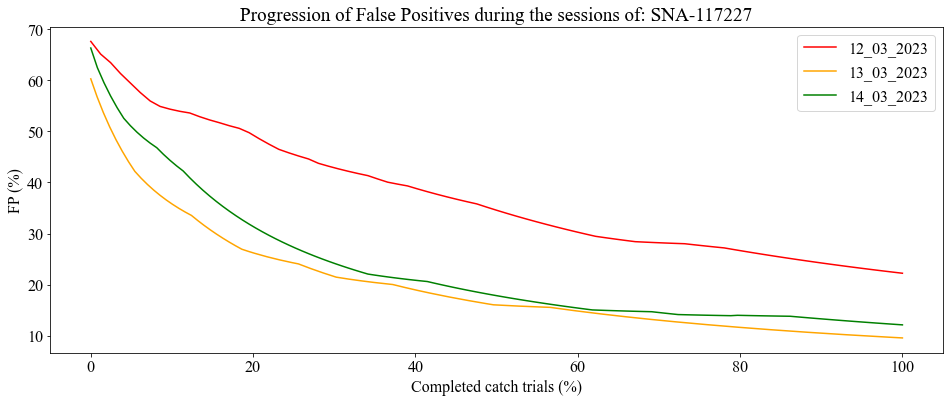

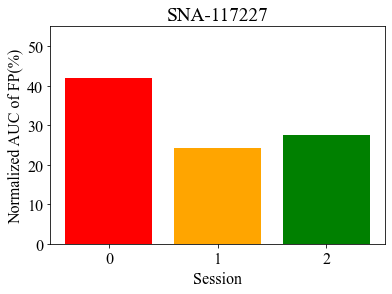

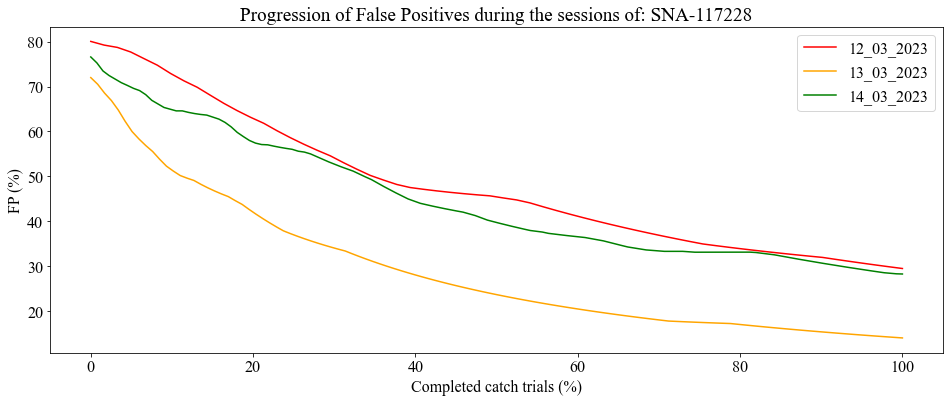

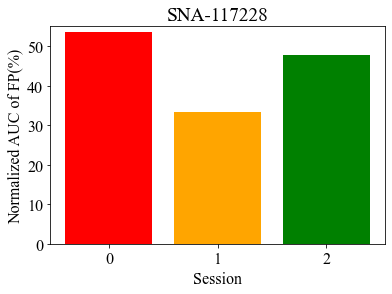

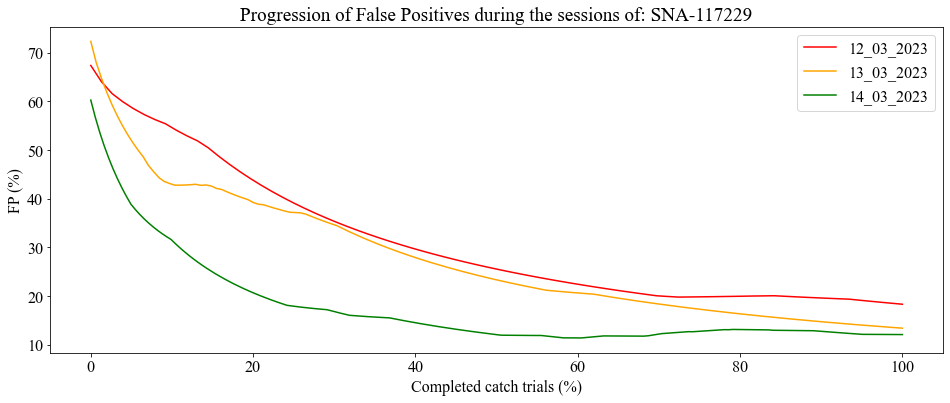

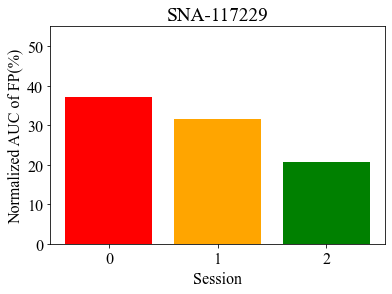

In [42]:
c = ['red', 'orange', 'green']
for n, mouse in enumerate(mice):
    FP_dict = plot_falsePositives(mouse, whiskey_n=10) #NOTE THAT THERE ARE 20 misstrails added!
    
    # For every session calculate & plot NORMALIZED AUC
    for n_sesh in FP_dict.keys():
        AUC = np.sum(FP_dict[n_sesh])/len(FP_dict[n_sesh])
        plt.bar(n_sesh, AUC, color=c[n_sesh])
    plt.xlabel('Session')
    plt.ylabel('Normalized AUC of FP(%)')
    plt.ylim([0, 55])
    plt.title(mouse.id)
    plt.show()    
    

In [13]:
'''Area under the curve of FPs(%)'''
# Calculate FP-percentage over trials

'Area under the curve of FPs(%)'

In [14]:
'''Notes on Jelte showing me: Mangin, Chen, Lin & Li (2023) bioxriv Behavioural measurements of motor readiness in mise
One of the last supplementary figures tries to show motivation over session.

Fig 1): Scatterplot with correlation line?
* y = (variance in) Response time (correlated with) Lickfrequency with BPOD 
* y = 
y = correlate whisker movement with response time?
y = correlate pupil dilation over trials with reward received
x = Water consumed or number of trials
or

'''

'Notes on Jelte showing me: Mangin, Chen, Lin & Li (2023) bioxriv Behavioural measurements of motor readiness in mise\nOne of the last supplementary figures tries to show motivation over session.\n\nFig 1): Scatterplot with correlation line?\n* y = (variance in) Response time (correlated with) Lickfrequency with BPOD \n* y = \ny = correlate whisker movement with response time?\ny = correlate pupil dilation over trials with reward received\nx = Water consumed or number of trials\nor\n\n'